In [1]:
!pip install numpy pandas matplotlib scikit-learn opencv-python tensorflow

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix


In [16]:
from google.colab import drive
drive.mount('/content/drive')

# Change the directory to where your dataset is stored
!ls '/content/drive/My Drive/Dataset'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dataset1  dataset2  dataset3  dataset4


In [4]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Resize to (128x128)
            images.append(img)
    return np.array(images)#load images to numpy array

# Load genuine and forged signatures
genuine_images = load_images_from_folder('/content/drive/My Drive/Dataset/dataset1/real')
forged_images = load_images_from_folder('/content/drive/My Drive/Dataset/dataset1/forge')

# Create labels: 1 for genuine, 0 for forged for classification
genuine_labels = np.ones(len(genuine_images))
forged_labels = np.zeros(len(forged_images))

# Combine images and labels
X = np.concatenate([genuine_images, forged_images], axis=0)
y = np.concatenate([genuine_labels, forged_labels], axis=0)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the images to the range [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0


In [6]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)


In [7]:
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # To avoid overfitting
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy']) # Use learning_rate instead of lr


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=60),
                    epochs=500,
                    validation_data=(X_test, y_test))


Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4931 - loss: 0.9793 - val_accuracy: 0.5417 - val_loss: 1.1051
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5023 - loss: 1.0402 - val_accuracy: 0.5417 - val_loss: 0.6973
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3722 - loss: 0.7397 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4097 - loss: 0.6951 - val_accuracy: 0.4583 - val_loss: 0.6936
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3866 - loss: 0.6990 - val_accuracy: 0.5417 - val_loss: 0.6917
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4500 - loss: 0.6964 - val_accuracy: 0.4583 - val_loss: 0.6970
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5347 - loss: 0.6905 - val_accuracy: 0.4583 - val_loss: 0.7012
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4954 - loss: 0.7014 - val_accuracy: 0.4583 - val_loss: 0.6943
Epoch 9/500
2/2 ━━━━

In [9]:
loss, accuracy = model.evaluate(X_test, y_test)

print(f'Test accuracy: {accuracy * 100:.4f}%')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9167 - loss: 0.2049
Test loss: 91.6667%


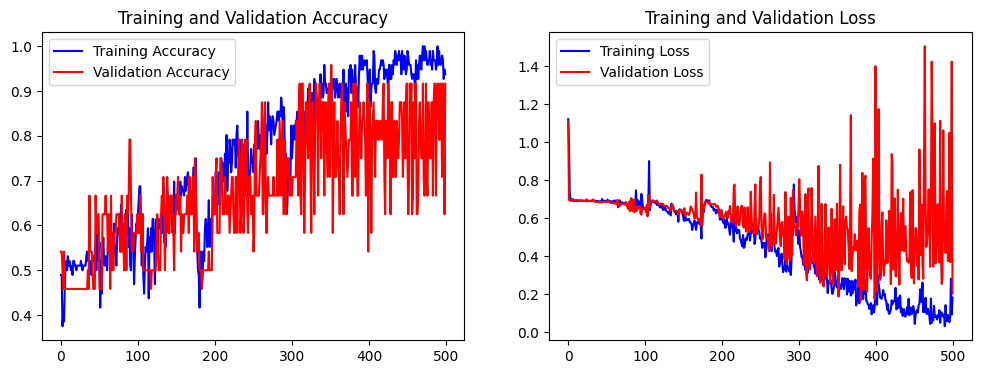

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


In [19]:
def predict_signature(model, img_path):
    # Check if the image file exists
    if not os.path.exists(img_path):
        print(f"Error: Image file not found at {img_path}")
        return

    img = cv2.imread(img_path)

    # Check if the image was loaded correctly
    if img is None:
        print(f"Error: Could not read image at {img_path}")
        return

    img = cv2.resize(img, (128, 128))
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Reshape for prediction

    prediction = model.predict(img)
    print(prediction)
    if prediction < 0.5:
        print("Forged Signature")
    else:
        print("Genuine Signature")

# Test the function
predict_signature(model, '/content/drive/My Drive/Dataset/dataset1/forge/02100002.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[0.03129397]]
Forged Signature


In [20]:
# Save model
model.save('signature_verification_cnn60_500.h5')

# Load model
from tensorflow.keras.models import load_model
model = load_model('signature_verification_cnn.h5')


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert predictions to binary

# Confusion matrix
print(confusion_matrix(y_test, y_pred))

# Classification report
print(classification_report(y_test, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
[[11  0]
 [ 2 11]]
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92        11
         1.0       1.00      0.85      0.92        13

    accuracy                           0.92        24
   macro avg       0.92      0.92      0.92        24
weighted avg       0.93      0.92      0.92        24

